1. Class Neighborhood-Based Collaborative Filtering

In [1]:
import pandas as pd 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

class NBCF(object):
    def __init__(self, Y_data, k, dist_func = cosine_similarity, test_size = 0.1, uuCF = 1):
        self.f = open('danhgia.dat', 'a+')
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
        self.test_size = test_size
    
    def normalize_Y(self):
        users = self.Y_data[:, 0]
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            ids = np.where(users == n)[0].astype(np.int32)
            item_ids = self.Y_data[ids, 1]
            ratings = self.Y_data[ids, 2]
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 
            self.mu[n] = m
            
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    def similarity(self):
        eps = 1e-6
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
        
    def refresh(self):
        """
        Normalize data and calculate similarity matrix again (after
        some few ratings added)
        """
        self.normalize_Y()
        self.similarity()
    
    def __pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        if u == 915 and i == 1681:
            print(ids)
        # Step 2: 
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        if u == 915 and i == 1681:
            print(users_rated_i)
        # Step 3: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        if u == 915 and i == 1681:
            print('sim:', sim)
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
    
    def recommend(self, u):
        """
        Determine all items should be recommended for user u.
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    recommended_items.append(i)
        
        return recommended_items 
    
    def recommend2(self, u):
        """
        Determine all items should be recommended for user u.
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
    
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    recommended_items.append(i)
        
        return recommended_items 

    def print_recommendation(self):
        """
        print all items which should be recommended for each user 
        """
        print('Recommendation: ')
        for u in range(self.n_users):
            recommended_items = self.recommend(u)
            if self.uuCF:
                print('    Recommend item(s):', recommended_items, 'for user', u)
            else: 
                print('    Recommend item', u, 'for user(s) : ', recommended_items)

    def RMSE(self, data_size, n_tests, Data_test):
        SE = 0
        for n in range(n_tests):
            if Data_test[n, 1] == 1681:
                pred = 0
            else:
                pred = self.pred(Data_test[n, 0], Data_test[n, 1], normalized = 0)
            SE += (pred - Data_test[n, 2])**2 

        RMSE = np.sqrt(SE/n_tests)
        if self.uuCF == 1:
            print('User-user CF, RMSE =', RMSE)
            self.f.write('%s::1::%d::cosine_similarity::%r::%r\r\n' % (str(data_size), self.k, self.test_size, RMSE))
        else:
            print('Item-item CF, RMSE =', RMSE)
            self.f.write('%s::0::%d::cosine_similarity::%r::%r\r\n' % (str(data_size), self.k, self.test_size, RMSE))
        self.f.close()

2. Lấy dữ liệu

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
print(os.listdir("mvl"))

['10M.dat', '20M.csv', '100K.base', '1M.dat']


In [3]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestemp']

# ratings_base_1 = pd.read_csv('mvl/100K.base', sep='\t', names=r_cols, encoding='latin-1', engine='python')
# ratings_base_2 = pd.read_csv('mvl/1M.dat', sep='::', names=r_cols, encoding='latin-1', engine='python')
ratings_base_3 = pd.read_csv('mvl/10M.dat', sep='::', names=r_cols, encoding='latin-1', engine='python')
# ratings_base_4 = pd.read_csv('mvl/20M.csv', names=r_cols, encoding='latin-1', engine='python')

# ratings_matrix_1 = ratings_base_1.as_matrix()
# ratings_matrix_2= ratings_base_2.as_matrix()
ratings_matrix_3 = ratings_base_3.as_matrix()
# ratings_matrix_4 = ratings_base_4.as_matrix()

# indices start from 0
# ratings_matrix_1[:, :2] -= 1
# ratings_matrix_2[:, :2] -= 1
ratings_matrix_3[:, :2] -= 1
# ratings_matrix_4[:, :2] -= 1

In [6]:
testSize = 0.1
# Data_train_1, Data_test_1= train_test_split(ratings_matrix_1, test_size=testSize, random_state=20)
# Data_train_2, Data_test_2= train_test_split(ratings_matrix_2, test_size=testSize, random_state=20)
Data_train_3, Data_test_3= train_test_split(ratings_matrix_3, test_size = testSize, random_state = 30)
# Data_train_4, Data_test_4= train_test_split(ratings_matrix_4, test_size=testSize, random_state=20)

# n_tests_1 = Data_test_1.shape[0]
# n_tests_2 = Data_test_2.shape[0]
n_tests_3 = Data_test_3.shape[0]
# n_tests_4 = Data_test_4.shape[0]
print(n_tests_3)

1000006


Training

In [ ]:
# rs_uu_1 = NBCF(Data_train_1, k = 40, test_size = testSize, uuCF = 1)
# rs_uu_1.refresh()

# rs_uu_2 = NBCF(Data_train_2, k = 40, test_size = testSize, uuCF = 1)
# rs_uu_2.refresh()

rs_uu_3 = NBCF(Data_train_3, k = 30, test_size = testSize, uuCF = 1)
rs_uu_3.refresh()
rs_uu_3.RMSE("10M", n_tests_3, Data_test_3)

# rs_uu_4= NBCF(Data_train_4, k = 30, test_size = testSize, uuCF = 1)
# rs_uu_4.refresh()
# # rs.print_recommendation()

# rs_ii_1 = NBCF(Data_train_1, k = 40, test_size = testSize, uuCF = 0)
# rs_ii_1.refresh()

# rs_ii_2 = NBCF(Data_train_2, k = 40, test_size = testSize, uuCF = 0)
# rs_ii_2.refresh()

rs_ii_3 = NBCF(Data_train_3, k = 10, test_size = testSize, uuCF = 0)
rs_ii_3.refresh()
rs_ii_3.RMSE("10M", n_tests_3, Data_test_3)


# rs_ii_4= NBCF(Data_train_4, k = 30, test_size = testSize, uuCF = 0)
# rs_ii_4.refresh()

/home/tran.thi.hai.ha/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tran.thi.hai.ha/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Đánh giá

In [ ]:
# rs_uu_1.RMSE("100K", n_tests_1, Data_test_1)
# rs_ii_1.RMSE("100K", n_tests_1, Data_test_1)

# rs_uu_2.RMSE("1M", n_tests_2, Data_test_2)
# rs_ii_2.RMSE("1M", n_tests_2, Data_test_2)

# rs_uu_4.RMSE("20M", n_tests_4, Data_test_4)
# rs_ii_4.RMSE("20M", n_tests_4, Data_test_4)

    Vẽ đồ thị đánh giá

   dataset  uuCF   k          dist_func  test_size      RMSE
0     100K     1  30  cosine_similarity       0.10  0.963706
1       1M     1  30  cosine_similarity       0.10  0.933049
2     100K     0  30  cosine_similarity       0.10  0.950537
3       1M     0  30  cosine_similarity       0.10  0.911812
4     100K     1  30  cosine_similarity       0.10  0.954972
5       1M     1  30  cosine_similarity       0.10  0.928659
6     100K     0  30  cosine_similarity       0.10  0.934541
7       1M     0  30  cosine_similarity       0.10  0.907685
8     100K     1  30  cosine_similarity       0.30  0.964410
9       1M     1  30  cosine_similarity       0.30  0.933850
10    100K     0  30  cosine_similarity       0.30  0.957389
11      1M     0  30  cosine_similarity       0.30  0.912921
12    100K     1  30  cosine_similarity       0.33  0.966732
13      1M     1  30  cosine_similarity       0.33  0.935216
14    100K     0  30  cosine_similarity       0.33  0.960403
15      1M     0  30  co

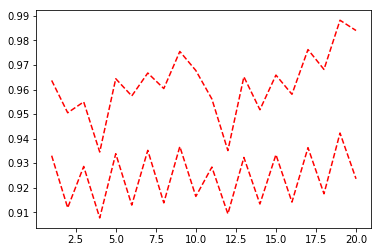

In [14]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

r_cols = ['dataset', 'uuCF', 'k','dist_func', 'test_size', 'RMSE']

RMSEs = pd.read_csv('danhgia.dat', sep='::', names=r_cols, encoding='latin-1', engine='python')

rs = RMSEs.as_matrix()
print(RMSEs)
dataset = rs[:, 0]

for n in ['100K', '1M']:
    ids = np.where(dataset == n)[0].astype(np.int32)
    items = rs[ids, 5]
    t = range(1, ids.shape[0] + 1, 1)
    plt.plot(t, items, 'r--')
    
plt.show()
    

# # evenly sampled time at 200ms intervals
# t = np.arange(0., 5., 0.2)

# # red dashes, blue squares and green triangles
# plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
# plt.show()